# Предварительный рабочий блокнот 
Подбор пайплайнов с помощью AutoML пакета [GAMA](https://openml-labs.github.io/gama/master)  
В качестве данных был выбран "широкий вариант" датасета **data_for_model.xlsx**

Тестировались разные базовые методы поиска оптимального пайплайна, включенные в GAMA:

- _Asynchronous Evolutionary Algorithm_: (генетический поиск) Evolve a population of machine learning pipelines, drawing new machine learning pipelines from the best of the population.

- _Asynchronous Successive Halving Algorithm_: A bandit-based approach where many machine learning pipelines iteratively get evaluated and eliminated on bigger fractions of the data. 


Разные тесты проводились с разным лимитом времени. от 3 мин до 3 часов


In [ ]:
# pip install gama

In [1]:
# Загрузка исходных данных 
import pandas as pd
import numpy as np
df = pd.read_excel('data_for_model.xlsx')
df = df.dropna()
df['trend'] = df['INR(MHO)'] - df['prev_INR(MHO)']
df.head()

,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31,trend
0,140361892057136,57,7.50,3.11,1,0,0,13,3.32,1,...,0,0,0,0,0,0,0,0,0,0.21
1,140361892057136,57,7.50,3.32,1,0,0,15,2.01,2,...,0,0,0,0,0,0,0,0,0,-1.31
2,140361892057264,50,5.00,2.01,0,1,0,26,2.75,1,...,0,0,0,0,0,0,0,0,0,0.74
3,140361892057392,53,6.25,1.42,1,0,0,15,2.56,1,...,0,0,0,0,0,0,0,0,0,1.14
4,140361892057392,53,6.25,2.56,1,0,0,49,2.80,2,...,0,0,0,0,0,0,0,0,0,0.24


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from gama import GamaRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import logging

## Вспомогательные подпрограммы

In [3]:
# Глобальные параметры прогонов
RANDOM_STATE = 0  
MAX_TIME = 180     # максимальное разрешенное время работы поиска (сек)
JOBS = 5           # количество задействованных ядер процессора для асинхронной обработки

In [4]:
def simplified_stratified_split(df, target_column='dose', *, n_bins=4, test_size=0.2, random_state=42):
    """
    Функция разбивает датафрейм на обучающий и тестовый наборы с учетом стратификации по квантильным значениям целевой переменной.

    Параметры:
    - df (pd.DataFrame): исходный датафрейм
    - target_column (str): имя целевого столбца, по которому будет осуществляться стратификация
    - n_bins (int): количество интервалов для разделения квантильных значений целевой переменной
    - test_size (float): доля данных, которая будет использоваться для тестового набора
    - random_state (int): seed для случайности при разбиении

    Возвращает:
    - train_df (pd.DataFrame): обучающий датафрейм
    - test_df (pd.DataFrame): тестовый датафрейм
    """

    # 1. Классификация значений целевой переменной (target_column) по квантилям
    binned_target= pd.qcut(df[target_column], q=n_bins, labels=False, duplicates='drop')

    # 2. Разбивка индексов датафрейма на обучающую и тестовую выборки с учетом стратификации по квантильным интервалам целевой переменной
    train_idx, test_idx = train_test_split(df.index, test_size=test_size, stratify=binned_target, random_state=random_state)

    # 3. Разбиение исходного датафрейма на обучающий и тестовый наборы на основе полученных индексов
    train_df = df.loc[train_idx]
    test_df = df.loc[test_idx]

    return train_df, test_df

In [5]:
def estimateG(predictions, y_test):
    # Рассчитываем основные метрики
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape_value = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    abs_diff = abs(y_test - predictions)
    diff_below_threshold = (abs_diff <= 0.5).sum()
    total_predictions = len(predictions)
    percentage_diff = (diff_below_threshold / total_predictions) * 100

    # Выводим результаты
    print("{:<55} {:>5.2f}".format("Средняя абсолютная ошибка (MAE):", mae))
    print("{:<55} {:>5.2f}".format("Среднеквадратичная ошибка (MSE):", mse))
    print("{:<55} {:>5.2f}".format("Коэффициент детерминации (R^2):", r2))
    print("{:<55} {:>5.2f}%".format("Средняя абсолютная процентная ошибка (MAPE):", mape_value))
    print("{:<55} {:>5.2f}%".format("Доля предсказаний с отклонением не более 0,5 мг:", percentage_diff))
    
    ae = round(abs(y_test - predictions)/0.5)
    col = ae
    size = ae*10
    plt.scatter(y_test, predictions, marker='o', c=col,  s=size)
    plt.title('Сравнение предсказанной и назначенной доз')
    
    plt.ylabel('Предсказанная доза')
    plt.xlabel('Назначенная доза');
    plt.grid()
    plt.show()
    return (mae, mse, r2, mape_value, percentage_diff)

In [6]:
def pipe_select(train_df, test_df, BaseSearch=None,
               scoring=('neg_mean_squared_error','r2'),regularize_length=True,
               verbose=logging.WARNING, preset='simple'): 
    X_train = train_df.drop('dose', axis=1)
    y_train = train_df['dose']
    X_test = test_df.drop('dose', axis=1)
    y_test = test_df['dose']

    gama = GamaRegressor(search=BaseSearch, max_total_time=MAX_TIME, 
                         scoring=scoring,                      
                         random_state=RANDOM_STATE, 
                         regularize_length=regularize_length,
                         # store="logs",
                         preset=preset,
                         n_jobs=JOBS, verbosity=verbose)

    print(f"Задание завершится приблизительно через {MAX_TIME / 60} мин.")
    gama.fit(X_train, y_train)
    print(gama.score(X_test, y_test))

    print(f"pipeline:\n{gama.export_script(f'gama_EA{MAX_TIME}.py')}\n")
    gama.export_script()
    
    predictions = gama.predict(X_test)

    scores = estimateG(predictions, y_test)
    return scores, gama

## Влияние стратификации 

In [7]:
def plot_split_hist(train,test, bins=4):
    yhist, ybins = np.histogram(test, bins=bins, range=None)
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    phist, pbins = np.histogram(train, bins=bins, range=None)
    pbins = 0.5 * (pbins[1:] + pbins[:-1])

    plt.plot(ybins,yhist, label='Test')
    plt.bar(pbins,phist, label='Train')
    plt.title('Распределение частей таргета')
    plt.xlabel('таргет')
    plt.ylabel('Количество')
    plt.legend()
    plt.tight_layout()
    plt.show()

Без стратификации


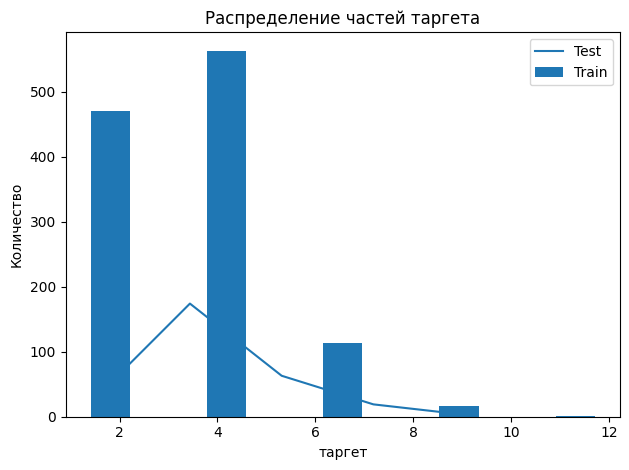

Со стратификацией


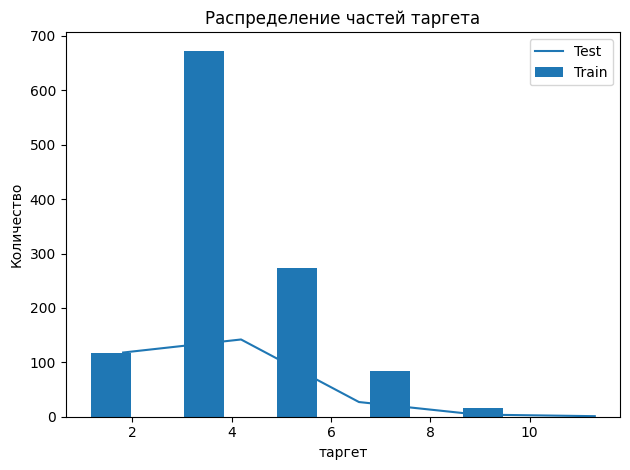

In [8]:
# Без стратификации
RANDOM_STATE = 0
BINS = 5
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 

y_train = train_df['dose']
y_test = test_df['dose']

print('Без стратификации')
plot_split_hist(y_train, y_test, bins=BINS)

# Со стратификацией

train_df, test_df = simplified_stratified_split(df, target_column='dose', n_bins=BINS, 
                                                test_size=0.2, random_state=RANDOM_STATE)

y_train = train_df['dose']
y_test = test_df['dose']

print('Со стратификацией')
plot_split_hist(y_train, y_test, bins=BINS)


## Генетический (эволюционный) поиск

In [9]:
# Что дает Asynchronous Evolutionary Algorithm: (генетический поиск) 

from gama.search_methods import AsyncEA

RANDOM_STATE = 0
MAX_TIME = 180
JOBS = 5

Задание завершится приблизительно через 3.0 мин.
0.7775416954336564
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from numpy import nan

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
('0', KNeighborsRegressor(n_neighbors=34, p=1, weights='distance'))])


Средняя абсолютная ошибка (MAE):                         0.54
Среднеквадратичная ошибка (MSE):                         0.78
Коэффициент детерминации (R^2):                          0.68
Средняя 

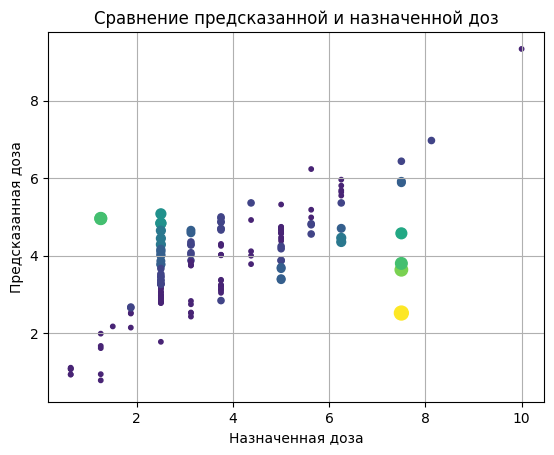

(0.5423725252052548, 0.7775416954336564, 0.6821745878013683, 18.767794787070706, 61.986301369863014)
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from numpy import nan

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
('0', KNeighborsRegressor(n_neighbors=34, p=1, weights='distance'))])




In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 
scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsyncEA(population_size=100),
               scoring=('neg_mean_squared_error','r2'),regularize_length=True
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_EA{MAX_TIME}.py')}\n")


Задание завершится приблизительно через 3.0 мин.
1.0101597991103723
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from numpy import nan
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import FeatureAgglomeration

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='manhattan', linkage='average')),
('0', KNeighborsRegressor(n_neighbors=94, p=1, weights='distance'))])


Средняя абсолютная ошибка (MAE):                         0.43
Среднеквадратичная ошибка (MSE):                         1.01
Коэффициент детерминации (R^2):                          0.63
Средняя абсолютная проц

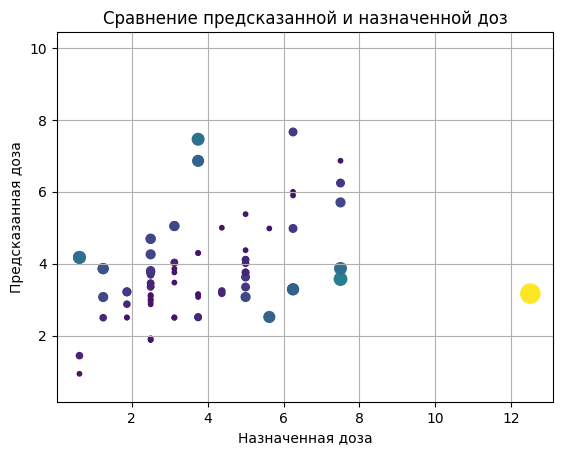

(0.4258196119507196, 1.0101597991103723, 0.6276479510996147, 16.61130045858022, 72.94520547945206)
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from numpy import nan
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import FeatureAgglomeration

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='manhattan', linkage='average')),
('0', KNeighborsRegressor(n_neighbors=94, p=1, weights='distance'))])




In [11]:
# Тоже самое, но 
# Со стратификацией Александра

train_df, test_df = simplified_stratified_split(df, target_column='dose', n_bins=4, 
                                                test_size=0.2, random_state=RANDOM_STATE)

scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsyncEA(population_size=100),
               scoring=('neg_mean_squared_error','r2'),regularize_length=True
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_EA_S{MAX_TIME}.py')}\n")

## Подбор с AsynchronousSuccessiveHalving 


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from gama import GamaRegressor
from sklearn.model_selection import train_test_split
from gama.search_methods import AsyncEA
from gama.search_methods import AsynchronousSuccessiveHalving

In [11]:

RANDOM_STATE = 0
MAX_TIME = 3600
JOBS = 4

Задание завершится приблизительно через 180.0 мин.
0.6599425564438111
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from numpy import nan
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import FeatureAgglomeration

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='euclidean', linkage='average')),
('0', KNeighborsRegressor(n_neighbors=38, p=1, weights='distance'))])


Средняя абсолютная ошибка (MAE):                         0.37
Среднеквадратичная ошибка (MSE):                         0.66
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная пр

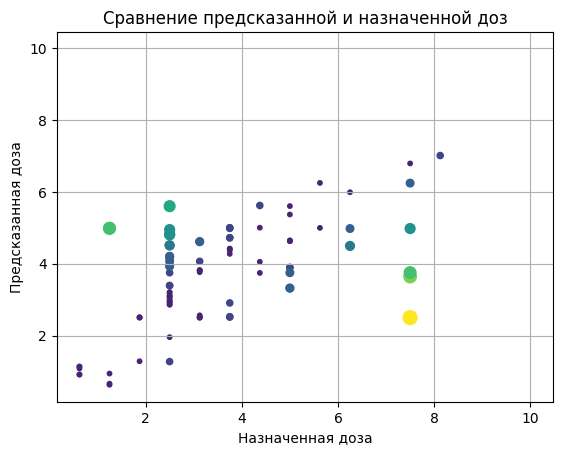

(0.3728135562558645, 0.6599425564438111, 0.7302440290199594, 13.4262161961925, 73.63013698630137)
pipeline:
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from numpy import nan
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import FeatureAgglomeration

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='euclidean', linkage='average')),
('0', KNeighborsRegressor(n_neighbors=38, p=1, weights='distance'))])




In [14]:

# Без стратификации
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 

scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsynchronousSuccessiveHalving(),
               scoring=('neg_mean_squared_error','r2'),regularize_length=True
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_ASH{MAX_TIME}.py')}\n")



In [ ]:
# # Со стратификацией Александра
# train_df, test_df = simplified_stratified_split(df, target_column='dose', n_bins=4, 
#                                                 test_size=0.2, random_state=RANDOM_STATE)
# ....

Задание завершится приблизительно через 60.0 мин.
0.6595001232884482
pipeline:
from sklearn.pipeline import Pipeline
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.one_hot import OneHotEncoder
from numpy import nan

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='manhattan', linkage='average')),
('0', KNeighborsRegressor(n_neighbors=93, p=1, weights='distance'))])


Средняя абсолютная ошибка (MAE):                         0.37
Среднеквадратичная ошибка (MSE):                         0.66
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная про

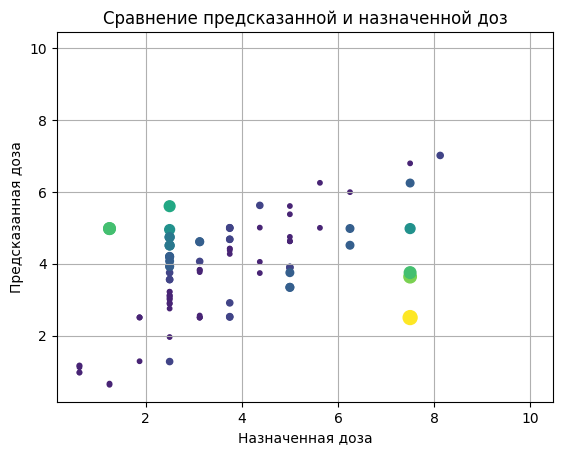

(0.37493875311478286, 0.6595001232884482, 0.7304248765562386, 13.590238507796618, 72.6027397260274)
pipeline:
from sklearn.pipeline import Pipeline
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.one_hot import OneHotEncoder
from numpy import nan

pipeline = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='manhattan', linkage='average')),
('0', KNeighborsRegressor(n_neighbors=93, p=1, weights='distance'))])




In [11]:
# Без стратификации 
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 

scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsynchronousSuccessiveHalving(),
               scoring=('neg_mean_squared_error','r2') #,regularize_length=False
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_ASH_2{MAX_TIME}.py')}\n")


Задание завершится приблизительно через 60.0 мин.
0.7257330252227264
pipeline:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from numpy import nan
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

pipeline_0 = Pipeline([('1', FeatureAgglomeration(affinity='l2', linkage='complete')),
('0', KNeighborsRegressor(n_neighbors=96, p=2, weights='distance'))])


pipeline_1 = Pipeline([(

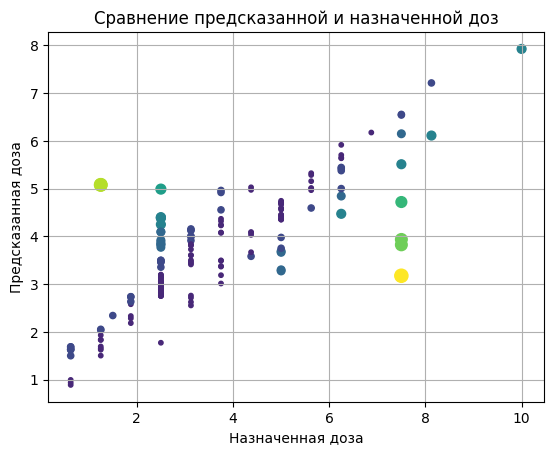

(0.5584822992839721, 0.7257330252227264, 0.7033517311776707, 21.395024218399165, 59.93150684931506)
pipeline:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from numpy import nan
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

pipeline_0 = Pipeline([('1', FeatureAgglomeration(affinity='l2', linkage='complete')),
('0', KNeighborsRegressor(n_neighbors=96, p=2, weights='distance'

In [13]:
# Без стратификации длинные pipelines  
# альтернативный режим подбора - для самого производительного пайплайна

MAX_TIME = 3600
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 

scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsynchronousSuccessiveHalving(),
               scoring=('neg_mean_squared_error','r2'),
               preset='performance'                 
               #,regularize_length=False
               )
print(scores)
print(f"pipeline:\n{estimator.export_script(f'gama_ASH_2{MAX_TIME}.py')}\n")

Задание завершится приблизительно через 10.0 мин.
0.7894576627843944
pipeline:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from numpy import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import Normalizer

pipeline_0 = Pipeline([('1', Nystroem(gamma=0.05, kernel='linear', n_components=3)),
('0', KNeighborsRegressor(n_neighbors=73, p=2, weights='distance'))])


pipeline_1 = Pipeline([('0', KNeighborsRegressor(n_neighbors=20, p=1, weights='distance'))])


pipeline_2 = Pipeline([('0', KNeighborsRegressor(n_neighbors=26, p=1, weights='distance'))])


pipeline_3 = Pipeline([

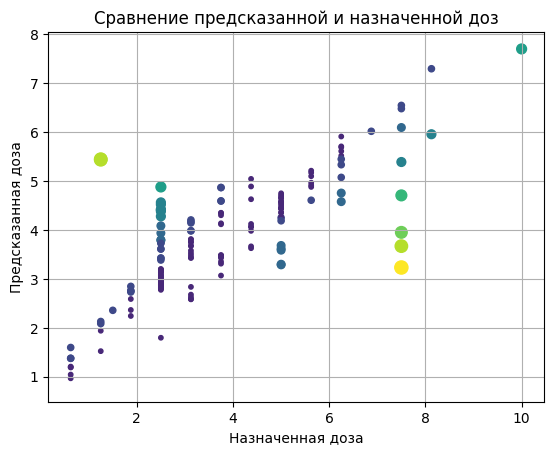

UnboundLocalError: local variable 'highest_rung_reached' referenced before assignment

In [7]:
# Проверка эффективности асамблирования моделей

from gama.search_methods import AsynchronousSuccessiveHalving
from gama.postprocessing import EnsemblePostProcessing

MAX_TIME = 600

train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)  #shuffle=False, 

X_train = train_df.drop('dose', axis=1)
y_train = train_df['dose']
X_test = test_df.drop('dose', axis=1)
y_test = test_df['dose']

ASH = GamaRegressor(search=AsynchronousSuccessiveHalving(), max_total_time=MAX_TIME,
                    post_processing=EnsemblePostProcessing(),
                    store="nothing", n_jobs=JOBS, scoring=('neg_mean_squared_error','r2'),
                    random_state=RANDOM_STATE #,regularize_length=False
                    )

print(f"Задание завершится приблизительно через {MAX_TIME / 60} мин.")
ASH.fit(X_train, y_train)
print(ASH.score(X_test, y_test))

print(f"pipeline:\n{ASH.export_script(f'gamaASH{MAX_TIME}.py')}\n")

predictions = ASH.predict(X_test)

scores, estimator = pipe_select(train_df, test_df, BaseSearch=AsynchronousSuccessiveHalving(),
               scoring=('neg_mean_squared_error','r2'),
               preset='performance'                 
               #,regularize_length=False
               )

ASH.fit(X_train, y_train)
print(ASH.score(X_test, y_test))

predictions = ASH.predict(X_test)

scores = estimateG(predictions, y_test)

print(scores)
print(f"pipeline:\n{ASH.export_script(f'gama_ASH_Asm{MAX_TIME}.py')}\n")

